# CSC421 Fall 2021 Assignment 4 
### Author: George Tzanetakis 

This notebook is based on the topics covered in **Chapter 14 - Probabilistic Reasoning over Time**, **Chapter 20 - Learning probabilistic models**, and **Chapter 19 Learning from Examples** from the book *Artificial Intelligence: A Modern Approach.*  You are welcome and actually it can be educational to look at the code at the aima-code repository as well as other code resources you can find on the web. However, make sure you understand any code that you incoporate. 

The assignment structure is as follows - each item is worth 1 point: 

1. Bayesian Network  (Basic) - express network and print CPT  
2. Bayesian Network  (Expected) - markdown and direct inference   
3. Bayesian Network  (Basic) -  approximate inference (rejection sampling and likelihood weighting) 
4. Bayesian Netowrk  (Advanced) - naive bayes of movie reviews as bayesian network 
5. Hidden Markov Models (Basic) - Use HMM to generate plausible DNA sequences and visualize 
6. Hidden Markov Models (Expected) - Learn HMM from samples for DNA sequences 
7. Hidden Markov Model (Expected) - Compare classification accuracy of ignoring transition matrix 
8. Hidden Markov Models (Advanced) - make up HMM scenario for activity detection using 2D coordinates and GMMs  
9. Classification (Basic) - Replicate movie review classification using bernoulli Naive Bayes in sklearn 
10. Classification(Expected) - Explore a standard classification problem with continuous attributes in sklearn 

The grading will be done in 0.5 increments. 1 point for correct answer, 0.5 points for partial or incorrect 
but reasonable answer and 0.0 for no answer or completely wrong answer. 

**Misunderstanding of probability may be the greatest of all impediments
to scientific literacy.** 

**Gould, Stephen Jay** 


# Question 1 (Basic)  - 1 point



<img src="dispnea.png">

Using the convetions for DBNs used in probability.ipynb (from the AIMA authors) encode the diapnea network shown above. Once you have constructed the Bayesian network display the cpt for the Lung Cancer Node (using the API provided not just showing the numbers).

The cell below contains the code that defined BayesNodes and BayesNetworks and the following cell 
shows an example of defining the Burglary network and performing a query using direct enumeration. 


In [49]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [50]:
import numpy as np 
import random 

def extend(s, var, val):
    """Copy dict s and extend it by setting var to val; return copy."""
    return {**s, var: val}

def event_values(event, variables):                                                                      
    """Return a tuple of the values of variables in event.                                               
    >>> event_values ({'A': 10, 'B': 9, 'C': 8}, ['C', 'A'])                                             
    (8, 10)                                                                                              
    >>> event_values ((1, 2), ['C', 'A'])                                                                
    (1, 2)                                                                                               
    """                                                                                                  
    if isinstance(event, tuple) and len(event) == len(variables):                                        
        return event                                                                                     
    else:                                                                                                
        return tuple([event[var] for var in variables])                                                  
                      
def probability(p):                                                                                      
    """Return true with probability p."""                                                                
    return p > random.uniform(0.0, 1.0)  
        
class ProbDist:
    """A discrete probability distribution. You name the random variable
    in the constructor, then assign and query probability of values.
    >>> P = ProbDist('Flip'); P['H'], P['T'] = 0.25, 0.75; P['H']
    0.25
    >>> P = ProbDist('X', {'lo': 125, 'med': 375, 'hi': 500})
    >>> P['lo'], P['med'], P['hi']
    (0.125, 0.375, 0.5)
    """

    def __init__(self, var_name='?', freq=None):
        """If freq is given, it is a dictionary of values - frequency pairs,
        then ProbDist is normalized."""
        self.prob = {}
        self.var_name = var_name
        self.values = []
        if freq:
            for (v, p) in freq.items():
                self[v] = p
            self.normalize()

    def __getitem__(self, val):
        """Given a value, return P(value)."""
        try:
            return self.prob[val]
        except KeyError:
            return 0

    def __setitem__(self, val, p):
        """Set P(val) = p."""
        if val not in self.values:
            self.values.append(val)
        self.prob[val] = p

    def normalize(self):
        """Make sure the probabilities of all values sum to 1.
        Returns the normalized distribution.
        Raises a ZeroDivisionError if the sum of the values is 0."""
        total = sum(self.prob.values())
        if not np.isclose(total, 1.0):
            for val in self.prob:
                self.prob[val] /= total
        return self

    def show_approx(self, numfmt='{:.3g}'):
        """Show the probabilities rounded and sorted by key, for the
        sake of portable doctests."""
        return ', '.join([('{}: ' + numfmt).format(v, p) for (v, p) in sorted(self.prob.items())])

    def __repr__(self):
        return "P({})".format(self.var_name)


class BayesNode:
    """A conditional probability distribution for a boolean variable,
    P(X | parents). Part of a BayesNet."""

    def __init__(self, X, parents, cpt):
        """X is a variable name, and parents a sequence of variable
        names or a space-separated string. cpt, the conditional
        probability table, takes one of these forms:

        * A number, the unconditional probability P(X=true). You can
          use this form when there are no parents.

        * A dict {v: p, ...}, the conditional probability distribution
          P(X=true | parent=v) = p. When there's just one parent.

        * A dict {(v1, v2, ...): p, ...}, the distribution P(X=true |
          parent1=v1, parent2=v2, ...) = p. Each key must have as many
          values as there are parents. You can use this form always;
          the first two are just conveniences.

        In all cases the probability of X being false is left implicit,
        since it follows from P(X=true).

        >>> X = BayesNode('X', '', 0.2)
        >>> Y = BayesNode('Y', 'P', {T: 0.2, F: 0.7})
        >>> Z = BayesNode('Z', 'P Q',
        ...    {(T, T): 0.2, (T, F): 0.3, (F, T): 0.5, (F, F): 0.7})
        """
        if isinstance(parents, str):
            parents = parents.split()

        # We store the table always in the third form above.
        if isinstance(cpt, (float, int)):  # no parents, 0-tuple
            cpt = {(): cpt}
        elif isinstance(cpt, dict):
            # one parent, 1-tuple
            if cpt and isinstance(list(cpt.keys())[0], bool):
                cpt = {(v,): p for v, p in cpt.items()}

        assert isinstance(cpt, dict)
        for vs, p in cpt.items():
            assert isinstance(vs, tuple) and len(vs) == len(parents)
            assert all(isinstance(v, bool) for v in vs)
            assert 0 <= p <= 1

        self.variable = X
        self.parents = parents
        self.cpt = cpt
        self.children = []

    def p(self, value, event):
        """Return the conditional probability
        P(X=value | parents=parent_values), where parent_values
        are the values of parents in event. (event must assign each
        parent a value.)
        >>> bn = BayesNode('X', 'Burglary', {T: 0.2, F: 0.625})
        >>> bn.p(False, {'Burglary': False, 'Earthquake': True})
        0.375"""
        assert isinstance(value, bool)
        ptrue = self.cpt[event_values(event, self.parents)]
        return ptrue if value else 1 - ptrue

    def sample(self, event):
        """Sample from the distribution for this variable conditioned
        on event's values for parent_variables. That is, return True/False
        at random according with the conditional probability given the
        parents."""
        return probability(self.p(True, event))

    def __repr__(self):
        return repr((self.variable, ' '.join(self.parents)))
    
    
class BayesNet:
    """Bayesian network containing only boolean-variable nodes."""

    def __init__(self, node_specs=None):
        """Nodes must be ordered with parents before children."""
        self.nodes = []
        self.variables = []
        node_specs = node_specs or []
        for node_spec in node_specs:
            self.add(node_spec)

    def add(self, node_spec):
        """Add a node to the net. Its parents must already be in the
        net, and its variable must not."""
        node = BayesNode(*node_spec)
        assert node.variable not in self.variables
        assert all((parent in self.variables) for parent in node.parents)
        self.nodes.append(node)
        self.variables.append(node.variable)
        for parent in node.parents:
            self.variable_node(parent).children.append(node)

    def variable_node(self, var):
        """Return the node for the variable named var.
        >>> burglary.variable_node('Burglary').variable
        'Burglary'"""
        for n in self.nodes:
            if n.variable == var:
                return n
        raise Exception("No such variable: {}".format(var))

    def variable_values(self, var):
        """Return the domain of var."""
        return [True, False]

    def __repr__(self):
        return 'BayesNet({0!r})'.format(self.nodes)
    
    
def enumerate_all(variables, e, bn):
    """Return the sum of those entries in P(variables | e{others})
    consistent with e, where P is the joint distribution represented
    by bn, and e{others} means e restricted to bn's other variables
    (the ones other than variables). Parents must precede children in variables."""
    if not variables:
        return 1.0
    Y, rest = variables[0], variables[1:]
    Ynode = bn.variable_node(Y)
    if Y in e:
        return Ynode.p(e[Y], e) * enumerate_all(rest, e, bn)
    else:
        return sum(Ynode.p(y, e) * enumerate_all(rest, extend(e, Y, y), bn)
                   for y in bn.variable_values(Y))

def enumeration_ask(X, e, bn):
    """
    [Figure 14.9]
    Return the conditional probability distribution of variable X
    given evidence e, from BayesNet bn.
    >>> enumeration_ask('Burglary', dict(JohnCalls=T, MaryCalls=T), burglary
    ...  ).show_approx()
    'False: 0.716, True: 0.284'"""
    assert X not in e, "Query variable must be distinct from evidence"
    Q = ProbDist(X)
    for xi in bn.variable_values(X):
        Q[xi] = enumerate_all(bn.variables, extend(e, X, xi), bn)
    return Q.normalize()

def consistent_with(event, evidence):
    """Is event consistent with the given evidence?"""
    return all(evidence.get(k, v) == v for k, v in event.items())

def prior_sample(bn):
    """
    [Figure 14.13]
    Randomly sample from bn's full joint distribution.
    The result is a {variable: value} dict.
    """
    event = {}
    for node in bn.nodes:
        event[node.variable] = node.sample(event)
    return event

def rejection_sampling(X, e, bn, N=10000):
    """
    [Figure 14.14]
    Estimate the probability distribution of variable X given
    evidence e in BayesNet bn, using N samples.
    Raises a ZeroDivisionError if all the N samples are rejected,
    i.e., inconsistent with e.
    >>> random.seed(47)
    >>> rejection_sampling('Burglary', dict(JohnCalls=T, MaryCalls=T),
    ...   burglary, 10000).show_approx()
    'False: 0.7, True: 0.3'
    """
    counts = {x: 0 for x in bn.variable_values(X)}  # bold N in [Figure 14.14]
    for j in range(N):
        sample = prior_sample(bn)  # boldface x in [Figure 14.14]
        if consistent_with(sample, e):
            counts[sample[X]] += 1
    return ProbDist(X, counts)

def weighted_sample(bn, e):
    """
    Sample an event from bn that's consistent with the evidence e;
    return the event and its weight, the likelihood that the event
    accords to the evidence.
    """
    w = 1
    event = dict(e)  # boldface x in [Figure 14.15]
    for node in bn.nodes:
        Xi = node.variable
        if Xi in e:
            w *= node.p(e[Xi], event)
        else:
            event[Xi] = node.sample(event)
    return event, w

def likelihood_weighting(X, e, bn, N=10000):
    """
    [Figure 14.15]
    Estimate the probability distribution of variable X given
    evidence e in BayesNet bn.
    >>> random.seed(1017)
    >>> likelihood_weighting('Burglary', dict(JohnCalls=T, MaryCalls=T),
    ...   burglary, 10000).show_approx()
    'False: 0.702, True: 0.298'
    """
    W = {x: 0 for x in bn.variable_values(X)}
    for j in range(N):
        sample, weight = weighted_sample(bn, e)  # boldface x, w in [Figure 14.15]
        W[sample[X]] += weight
    return ProbDist(X, W)


In [51]:
   burglary = BayesNet([
        ('Burglary', '', 0.001),
        ('Earthquake', '', 0.002),
        ('Alarm', 'Burglary Earthquake',
         {(True, True): 0.95, (True, False): 0.94, (False, True): 0.29, (False, False): 0.001}),
        ('JohnCalls', 'Alarm', {True: 0.90, False: 0.05}),
        ('MaryCalls', 'Alarm', {True: 0.70, False: 0.01})
    ])
    
print(burglary.variable_node('Alarm').cpt)
ans_dist = enumeration_ask('Burglary', {'JohnCalls': True, 'MaryCalls': True}, burglary)
print(ans_dist[True],ans_dist[False])


p = rejection_sampling('Burglary', dict(JohnCalls=True, MaryCalls=True), burglary, 10000)
print(p[True])

likelihood_weighting('Burglary', dict(JohnCalls=True, MaryCalls=True),burglary, 10000).show_approx()

{(True, True): 0.95, (True, False): 0.94, (False, True): 0.29, (False, False): 0.001}
0.2841718353643929 0.7158281646356071
0.35294117647058826


'False: 0.744, True: 0.256'

In [52]:
# YOUR CODE GOES HERE 
dispnea = BayesNet([
        ('VisitAsia', '', 0.001),
        ('Smoker', '', 0.5),
        ('Tuberculosis', 'VisitAsia', {True: 0.05, False: 0.01}), 
        ('LungCancer', 'Smoker', {True: 0.1, False: 0.01}),
        ('Bronchitis', 'Smoker', {True: 0.6, False: 0.3}),
        ('EitherTorL', 'Tuberculosis LungCancer', {(True, True): 1, (True, False): 1, (False, True): 1, (False, False): 0}),
        ('PosXray', 'EitherTorL', {True: 0.98, False: 0.05}),
        ('Dispnea', 'EitherTorL Bronchitis', {(True, True): 0.9, (True, False): 0.7, (False, True): 0.8, (False, False): 0.1})
    ])

print(dispnea.variable_node('LungCancer').cpt)
p = dispnea.variable_node('LungCancer').cpt
print('Conditional Probability Table for Lung Cancer')
print('+----------+------------+----------------+')
print('|----------|lung cancer | not lung cancer|')
print('|smoker    |    {}     |       {}      |'.format(p[True,], 1 - p[True,]))
print('|not smoker|    {}    |       {}     |'.format(p[False,], 1 - p[False,]))
print('+----------+------------+----------------+')



{(True,): 0.1, (False,): 0.01}
Conditional Probability Table for Lung Cancer
+----------+------------+----------------+
|----------|lung cancer | not lung cancer|
|smoker    |    0.1     |       0.9      |
|not smoker|    0.01    |       0.99     |
+----------+------------+----------------+


# Question 2 (Expected) 1 point 

Answer using exact inference with enumeration the following query: given that a patient has been in Asia and has a positive xray, what is the likelihood of having dispnea?

Write down using markdown the expression that corresponds to this query and the corresponding numbers from the CPT. There will be multiple sums and subscripts. Calculate the result using a calculator.

Write code for the same query using enumeration_ask and confirm that the result is the same for the same query.



#using variable elimination:

$P(d|a,x) = \Sigma_{A,S,T,L,B,E,X,D} P(d|e,b) * P(e|t,l) * P(b|s) * P(l|s) *P(t|a) * P(s) * P(a)$

$\Sigma_{A} P(t|a) * P(a) = f_{1}(t)$

$         = \Sigma_{S,T,L,B,E,X,D} P(d|e,b) * P(e|t,l) * P(b|s) * P(l|s) * P(s) * f_{1}(t)$

$\Sigma_{X} P(X) = 1$

$\Sigma_{S} P(b|s) * P(l|s) * P(s) = f_{2}(b,l)$

$          = \Sigma_{T,L,B,E} P(d|e,b) * P(e|t,l) *f_{1}(t) * f_{2}(b,l)$

$\Sigma_{T} P(e|l,t) * f_{1}(t) = f_{3}(a,l)$

$          = \Sigma_{L,B,E} P(d|b,e) * f_{2}(b,l) * f_{3}(a,l)$

$\Sigma_{L} f_{2}(b,l) * f_{3}(a,l) = f_{4}(a,b)$

$          = \Sigma_{B,E} P(d|e,b) * f_{4}(a,b)$

$\Sigma_{E}\Sigma_{B} P(d|e,b) * f_{4}(a,b) = f_{5}(a)$

$          = \Sigma_{E} f_{5}(a)$

$ = aprroximately   0.68$

Mutlitplying (across rows) and summing (final column) the values using given VisitAsia and PosXray as true to find the probability of having dyspena. Lowercase letters indicate false random variables and uppercase letters represent true random variables. Probablity table headings are in this order:  
P(d|e,b) P(x|e) P(b|s) P(e|l,t) P(l|s) P(T|A) P(A) P(S) (probability)

Table for variable multiplication:  
  

1. STBLE 0.9  0.98  0.6   1   0.1  0.05  0.01  0.5  0.00001323 

2. STBLe 0.8  0.05  0.6   0   0.1  0.05  0.01  0.5  0   

3. STBlE 0.9  0.98  0.6   1   0.9  0.05  0.01  0.5  0.00011907  

4. STBle 0.8  0.05  0.6   0   0.9  0.05  0.01  0.5  0   

5. STbLE 0.7  0.98  0.4   1   0.1  0.05  0.01  0.5  0.00000686  

6. STbLe 0.1  0.05  0.4   0   0.1  0.05  0.01  0.5  0   

7. STblE 0.7  0.98  0.4   1   0.9  0.05  0.01  0.5  0.00006174   

8. STble 0.1  0.05  0.4   0   0.9  0.05  0.01  0.5  0  

9. StBLE 0.9  0.98  0.6   1   0.1  0.95  0.01  0.5  0.00025137  

10. StBLe 0.8  0.05  0.6   0   0.1  0.95  0.01  0.5  0   

11. StBlE 0.9  0.98  0.6   0   0.9  0.95  0.01  0.5  0    

12. StBle 0.8  0.05  0.6   1   0.9  0.95  0.01  0.5  0.0001026   

13. StbLE 0.7  0.98  0.4   1   0.1  0.95  0.01  0.5  0.00013034  

14. StbLe 0.1  0.05  0.4   0   0.1  0.95  0.01  0.5  0   

15. StblE 0.7  0.98  0.4   0   0.99  0.95  0.01  0.5  0   

16. Stble 0.1  0.05  0.4   1   0.99  0.95  0.01  0.5  0.000009405  

17. sTBLE 0.9  0.98  0.3   1   0.01  0.05  0.01  0.5  0.000000661  

18. sTBLe 0.8  0.05  0.3   0   0.01  0.05  0.01  0.5  0   

19. sTBlE 0.9  0.98  0.3   1   0.99  0.05  0.01  0.5  0.000065488   

20. sTBle 0.8  0.05  0.3   0   0.99  0.05  0.01  0.5  0  

21. sTbLE 0.7  0.98  0.7   1   0.01  0.05  0.01  0.5  0.0000012  

22. sTbLe 0.1  0.05  0.7   0   0.01  0.05  0.01  0.5  0   

23. sTblE 0.7  0.98  0.7   1   0.99  0.05  0.01  0.5  0.00011849  

24. sTble 0.1  0.05  0.7   0   0.99  0.05  0.01  0.5  0   

25. stBLE 0.9  0.98  0.3   1   0.01  0.95  0.01  0.5  0.000012568   

26. stBLe 0.8  0.05  0.3   0   0.01  0.95  0.01  0.5  0   

27. stBlE 0.9  0.98  0.3   0   0.99  0.95  0.01  0.5  0   

28. stBle 0.8  0.05  0.3   1   0.99  0.95  0.01  0.5  0.00005643   

29. stbLE 0.7  0.98  0.7   1   0.01  0.95  0.01  0.5  0.000022809  

30. stbLe 0.1  0.05  0.7   0   0.01  0.95  0.01  0.5  0   

31. stblE 0.7  0.98  0.7   0   0.99  0.95  0.01  0.5  0   
 
32. stble 0.1  0.05  0.7   1   0.99  0.95  0.01  0.5  0.000016458  
  
The summation of the probabilities is: 0.000870229 which is not yet normalized

In [53]:
# YOUR CODE GOES HERE 

ans = enumeration_ask('Dispnea', {'VisitAsia': True, 'PosXray': True}, dispnea)
print(ans[True], ans[False])




0.6811011940658546 0.3188988059341455


# QUESTION 3 (Basic) - 1 point

Answer using approximate inference the same query using both rejection sampling and likelihood weighting.

In [54]:
# YOUR CODE GOES HERE
#running rejection sampling a few times to show that there is variablility 
#in the results depending on the samples taken
print('Testing rejection sampling 10 times')
for i in range(0,10):
    try: 
        p = rejection_sampling('Dispnea', dict(VisitAsia=True, PosXray=True), dispnea, 10000)
        print('{}: The probability distribution of variable Dispnea given the evidence is: {}'.format(i+1,p[True]))
        
    except ZeroDivisionError:
        print('{}: All N samples were rejected in rejection sampling.'.format(i+1))
        continue
        
print('Testing using liklihood weighting')
likelihood_weighting('Dispnea', dict(VisitAsia=True, PosXray=True), dispnea, 10000).show_approx()


Testing rejection sampling 10 times
1: The probability distribution of variable Dispnea given the evidence is: 0
2: The probability distribution of variable Dispnea given the evidence is: 0.6666666666666666
3: All N samples were rejected in rejection sampling.
4: The probability distribution of variable Dispnea given the evidence is: 0.5
5: The probability distribution of variable Dispnea given the evidence is: 0.5
6: The probability distribution of variable Dispnea given the evidence is: 0.5
7: All N samples were rejected in rejection sampling.
8: The probability distribution of variable Dispnea given the evidence is: 0.0
9: The probability distribution of variable Dispnea given the evidence is: 0.5
10: The probability distribution of variable Dispnea given the evidence is: 0.5
Testing using liklihood weighting


'False: 0.323, True: 0.677'

# QUESTION 4 (ADVANCED) - 1 point 

A Naive Bayes classifier can be considered as a Bayesian Network. The classification problem can then be expressed as setting all the variables corresponding to the features as evidence and querying the probability for the class. Express the Bernoulli Naive Bayes classifier you implemented in the previous assignment as a Bayesian Network using the probability.ipynb conventions used in this notebook. Now that you have a DBN express and solve the classification problem as a query and go over all the previous steps for this particular problem. More specifically do exact inference by enumeration, approximate inference by rejection sampling to answer the query and show the results. Use 4 specific examples (2 positive and 2 negative) from the training dataset to show how the prediction using the Bayesian network works.



In [55]:
# YOUR CODE GOES HERE 


# Question 5 (Basic) -1 point


The next three question explore hidden markov models (HMMs) and use the hmmlearn Python library. You can use the code for the weather example in the probabilistic reasoning over time notebook we covered in class as a template for writing your code. 

The problem used in inspired by the use of HMMs in bioinformatics. 
There are several simplifications made to make it reasonable as part of an assignment. DNA sequences can be considered strings over an alphabet of 4 symbols/nucleobases **A,C,T,G (adenine, cytosine, thymine, guanine**. Parts of a DNA sequence are dense with C and G and other parts are sparse with C and G and it is of interest to biologists to identify these regions. 

We will model the CG-dense **(CGD)** and **CG-sparse** (CGS) as hidden states and the nucleobases are the observations. Through experimental data we have the following information: 

1. The transition probability from CGD to CGS is 0.37 and the probability of staying in CGD is 0.63. The transition probability from CGS to CGD is similarly 0.37 with 0.63 being the probability of staying in CGS. 

2. The observation probabilities of CGD regions are: A: 0.15, C:0.35, G: 0.35, and T:0.15. The observation probabilities of CGS regions are: A: 0.40, C: 0.10, G: 0.10, T: 0.40 

3. You can assume that the initial state probabilities are the same (0.5) 

4. For visualization of the DNA sequences use the following color mapping: A: red, C: green, T: blue, G: yellow, and for CGD: black 
and CGS: white 


Define this HMM model using the **hmmlearn** conventions. Then use the created model to generate a sequence of 1000 samples (i.e both hidden states and corresponding observations). Use the colors above 
to visualize the sequence of samples. 


In [56]:
pip install hmmlearn

  Using cached hmmlearn-0.2.6-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.whl (369 kB)
Note: you may need to restart the kernel to use updated packages.


In [57]:
pip install matplotlib

  Using cached matplotlib-3.5.0-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached Pillow-8.4.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Using cached setuptools_scm-6.3.2-py3-none-any.whl (33 kB)
  Using cached kiwisolver-1.3.2-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached fonttools-4.28.3-py3-none-any.whl (884 kB)
  Using cached tomli-1.2.2-py3-none-any.whl (12 kB)
Note: you may need to restart the kernel to use updated packages.


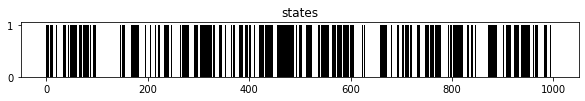

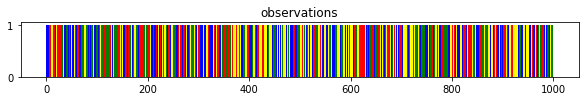

In [58]:
# YOUR CODE GOES HERE 
import numpy as np 
from hmmlearn import hmm
from scipy import stats
import matplotlib.pyplot as plt


def plot_DNA_samples(samples, state2color, title): 
    colors = [state2color[x] for x in samples]
    x = np.arange(0, len(colors))
    y = np.ones(len(colors))
    plt.figure(figsize=(10,1))
    plt.bar(x, y, color=colors, width=1)
    plt.title(title)

#######hmmlearn---------------------------------

# transmat = np.array([[0.37, 0.63],
#                     [0.63, 0.37]])

transmat = np.array([[0.15, 0.85],
                    [0.85, 0.15]])

start_probs = np.array([0.5,0.5])

emission_probabilities = np.array([[0.10,0.10,0.40,0.40],[0.35,0.35,0.15,0.15]])

model = hmm.MultinomialHMM(n_components=2)
model.startprob_ = start_probs 
model.transmat_ = transmat 
model.emissionprob_ = emission_probabilities

X, Z = model.sample(1000)

state2color = {} 
state2color[0] = 'black'
state2color[1] = 'white'
plot_DNA_samples(Z, state2color, 'states')

samples = [item for sublist in X for item in sublist]
obj2color = {} 
obj2color[0] = 'red'
obj2color[1] = 'green'
obj2color[2] = 'yellow'
obj2color[3] = 'blue'
plot_DNA_samples(samples, obj2color, 'observations')


# Question 6 (Expected) -1 point

Generate 10000 samples using the defined hmm for generating DNA sequences. Learn the HMM in an unsupervised fashion similarly to what we did with the weather example i.e only use the observation samples not the "hidden" states. Constrast the original HMM to the HMM estimated from the data. 


In [59]:
# YOUR CODE GOES HERE 
m1, m2 = model.sample(10000)
est_model = hmm.MultinomialHMM(n_components = 2, n_iter = 1000000).fit(m1)

m3 = est_model.predict(m1)
state2color = {} 
state2color[1] = 'black'
state2color[0] = 'white'


print('Transition matrix')
print("Estimated model")
print(est_model.transmat_)
print('Original Model')
print(model.transmat_)
print("Emission probabilities")
print("Estimated model")
print(est_model.emissionprob_)
print("Original model")
print(model.emissionprob_)

Transition matrix
Estimated model
[[0.12851978 0.87148022]
 [0.83944903 0.16055097]]
Original Model
[[0.15 0.85]
 [0.85 0.15]]
Emission probabilities
Estimated model
[[0.34361305 0.35384603 0.13982696 0.16271396]
 [0.1095737  0.09932463 0.41737085 0.37373081]]
Original model
[[0.1  0.1  0.4  0.4 ]
 [0.35 0.35 0.15 0.15]]


# Question 7 (Expected) -1 point

Write a function called **classification_accuracy** that takes as input 
two arrays or lists of states and returns the number of states that are the same in both lists as a percentage. 

Consider the original sequences of states of the generated samples 
as ground truth. Then use the estimated model from the previous 
question to generate predicted states from the observation samples. 
That is the maximum likelihood sequence estimation problem. 
Note that the predicted states might be inverted compared to the original and you need to deal with that in your code (see the class notebook for details). Now compute the accuracy between the predicted 
sequence of states and the ground truth sequence of states. 
This is similar to the visual comparison of the original and predicted states in the provided notebook but using a quantified 
metric rather than a visualization. 

Now replace the transition model of the original HMM with a transition model that is all 0.5 i.e there is no transition information. Effectively this disregards any temporal dependenices and each time step is decided independently. In fact it corresponds to a Naive Bayes classifier with a single feature which is the nucleobase observation. 

What is the classification accuracy in this case?

In [61]:
# YOUR CODE GOES HERE 
#using a new batch of samples from the model for each iterration of testing 

#test1 = model.sample(10)


#print(test1[1][0])

def classification_accuracy(arr1, arr2):
    correct = 0 
    total = 0
    for i in range(len(arr1)):
        if arr1[1][i] == arr2[1][i]:
            correct += 1
            total += 1
        else:
            total += 1
    acc = correct / total
    if acc < 0.5:
        return acc
    else:
        inv_corr = 0
        inv_tot = 0
        inv_indx = len(arr2)-1
        for i in range(len(arr1)):
            if arr1[1][i] == arr2[1][inv_indx]:
                inv_corr += 1
                inv_tot += 1
                inv_indx -= 1
            else:
                inv_tot += 1
                inv_indx -= 1
        acc = inv_corr / inv_tot
        return acc
    

for i in range(15):  
    X = est_model.sample(10000)
    Y = model.sample(10000)
    acc = classification_accuracy(Y, X)
    print('{}: percent accuracy is: {:.2f}'.format(i+1, acc * 100 ))

test1 = model.sample(10)


1: percent accuracy is: 50.00
2: percent accuracy is: 0.00
3: percent accuracy is: 0.00
4: percent accuracy is: 50.00
5: percent accuracy is: 0.00
6: percent accuracy is: 0.00
7: percent accuracy is: 0.00
8: percent accuracy is: 0.00
9: percent accuracy is: 50.00
10: percent accuracy is: 0.00
11: percent accuracy is: 0.00
12: percent accuracy is: 0.00
13: percent accuracy is: 50.00
14: percent accuracy is: 50.00
15: percent accuracy is: 50.00


# Question 8 (Advanced) -1 point

This question is a bit more open ended, will require some creativity and extra work. Consider the following problem: during your day your cell phone collects location data in terms of x,y coordinates. You do different activities such as going to university, eating, going to the gym. These activities take place in particular locations such as Restaurant A and Restaurant B or Gym A, Gym B and each particular location can be thought of as a two-dimensional Gaussian distribution of location points. If you consider the activity as the hidden state and the location as the observation you have a Hidden Markov Model. Because activities take place in multiple locations you can model this as a Gaussian Mixture Model (GMM). Each Gaussian will be multivariate 2D Gaussian distribution characterized by two means and and a 2 by 2 covariance matrix.

Consider a hypothetical scenario with 3 activities (eat, study, exercise) and 3 locations (GMM components) for each activity. You will need to do some reading about how GMMs work. You can come up 
with reasonable estimates for the associated parameters. 

Basically the goal is the follow the format of the Markov Chain and HMM notebook and create appropriate visualizations using this problem.

Visualize on a 2D plane using circles the different locations and corresponding mixture components
Generate a dataset using a Hidden Markov Model of the problem
Visualize the dataset on a 2D plane
Show how you can learn the parameters of this HMM using https://hmmlearn.readthedocs.io/en/latest/api.html#hmmlearn.hmm.GMMHMM



In [62]:
# YOUR CODE GOES HERE 


# Question 9 (Basic) - 1 point





In [63]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


The goal of this question is to get some familiarity with scikit-learn: https://scikit-learn.org/stable/

Replicate movie review classification from the previous assignment using bernoulli Naive Bayes in sklearn. This is relatively straightforward you simply need to create appropriate binary feature matrix and labels. Report on the classification accuracy and confusion matrix for that problem using 3-fold cross-validation. 
You will need to consult the execllent sklearn documentation for details. 


In [64]:
# YOUR CODE GOES HERE 
# this question assumes that the pos.zip and neg.zip files are in the same directory as the notebook. The file classification
#uses them to create the binary array data used in the BernoulliNB classification. 
import os 
import zipfile
import numpy as np 
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

words = ['awful', 'bad', 'boring', 'dull', 'effective', 'great', 'hilarious']

def env_setup(path, new_path):
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(new_path)

        
        
def vector_classification(target_words, folder, binV =None):
    wc_dict = {k:0 for k in target_words}
    bin_vectors = []
    for filename in os.listdir(folder):
        if filename.endswith('.txt'):
            bin_vector = [0 for i in range(len(target_words))]
            try:
                with open(os.path.join(folder, filename), 'r') as f:
                    for line in f:
                        for word in line.split():
                            if word in target_words:
                                bin_vector[target_words.index(word)] = 1
                            else:
                                pass
                    bin_vectors.append(bin_vector)
            except IsADirectoryError:
                print('The given directory {} or {} is not in this directory.'.format(folder, filename))
                continue
            except FileNotFoundError:
                print('The file is not in this directory.')
                continue 
        else:
            continue 
    for i in bin_vectors:
        count = 0
        for j in i:
            if j == 1:
                wc_dict[words[count]] += 1
                count += 1
                continue 
            else: 
                count += 1
                continue 
    if binV == True:
        probs = {}
        for k,v in wc_dict.items():
            probs[k] = round((v/len(bin_vectors)*100),2)
        return probs
    else:
        return bin_vectors


def array_def(arr1, arr2):
    a = np.zeros(shape=(2000,7))
    for i in range(len(arr1)):
        a[i] = arr1[i]
    secondary = 0
    for j in range(2000 - len(arr2)):
        a[1000+j] = arr2[secondary]
        secondary+=1
    return a


path = './pos.zip'
new_path = './pos'
env_setup(path, new_path)
path = './neg.zip'
new_path = './neg'
env_setup(path, new_path)


X = vector_classification(words, './pos/pos/')
Y = vector_classification(words, './neg/neg/')


pos_probs = vector_classification(words, './pos/pos/', binV=True) #dictionary of positive review word probabilities
neg_probs = vector_classification(words, './neg/neg/', binV=True) #dictionary of negtive review word probabilities

merged = array_def(X, Y) #create pos and neg array for bernoulliNB classification

Y_1 = []
for i in range(1000):
    Y_1.append(1)
for i in range(1000):
    Y_1.append(0)


k_fold = KFold(n_splits=3, shuffle=True, random_state=0)
clf = BernoulliNB()
print('Reporting accuracy for BernoulliNB with 3 K-fold for movie review classification is:')
print(cross_val_score(clf, merged, Y_1, cv=k_fold, n_jobs=1))
print('Classification wiht BernoulliNB:')
clf.fit(merged,Y_1)
pred = clf.predict(merged)
target_names = ['Positive', 'Negative']
print(classification_report(Y_1, pred, target_names=target_names))


Reporting accuracy for BernoulliNB with 3 K-fold for movie review classification is:
[0.68065967 0.67466267 0.66666667]
Classification wiht BernoulliNB:
              precision    recall  f1-score   support

     class 0       0.70      0.60      0.65      1000
     class 1       0.65      0.75      0.70      1000

    accuracy                           0.67      2000
   macro avg       0.68      0.67      0.67      2000
weighted avg       0.68      0.67      0.67      2000



# Question 10 (Expected) - 1 point 

The goal of this question is to give you some familiarity with having continuous features and comparing different classifiers. For this question use the breast cancer dataset from sklearn: 
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer

Train and compare three classifiers using this dataset using 3-fold 
cross-validation to calculate the classification accuracy and classification report: 

1. The Gaussian Naive Bayes classifier (with default parameters) 
(from sklearn.naive_bayes import GaussianNB) 
2. Linear support vector machine (with default parameters) 
(from sklearn.svm import LinearSVC) 
3. Decision tree (with default parameters) 
(from sklearn.tree import DecisionTreeClassifier)




In [66]:
from sklearn.datasets import load_breast_cancer
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import numpy as np 
import warnings
warnings.filterwarnings("ignore")



data = load_breast_cancer(return_X_y=True, as_frame=False)

X = data[0] #data 
Y = data[1] #target



print('Classification wiht GuassianNB:')
k_fold = KFold(n_splits=3, shuffle=True, random_state=0)
clf = GaussianNB()
print(cross_val_score(clf, X, Y, cv=k_fold, n_jobs=1))
clf.fit(X,Y)
pred = clf.predict(X)
target_names = ['malignant', 'benign']
print(classification_report(Y, pred, target_names=target_names))


print('Classification accuracy with LinearSVC:')
k_fold = KFold(n_splits=3, shuffle=True, random_state=0)
clf = LinearSVC()
print(cross_val_score(clf, X, Y, cv=k_fold, n_jobs=1))
clf.fit(X,Y)
pred = clf.predict(X)
target_names = ['malignant', 'benign']
print(classification_report(Y, pred, target_names=target_names))

print('Classification accuracy with DecisionTreeClassifier:')
k_fold = KFold(n_splits=3, shuffle=True, random_state=0)
clf = DecisionTreeClassifier()
print(cross_val_score(clf, X, Y, cv=k_fold, n_jobs=1))
clf.fit(X,Y)
pred = clf.predict(X)
target_names = ['malignant', 'benign']
print(classification_report(Y,pred, target_names=target_names))
                                    

Classification wiht GuassianNB:
[0.92105263 0.94736842 0.94179894]
              precision    recall  f1-score   support

   malignant       0.95      0.89      0.92       212
      benign       0.94      0.97      0.95       357

    accuracy                           0.94       569
   macro avg       0.94      0.93      0.94       569
weighted avg       0.94      0.94      0.94       569

Classification accuracy with LinearSVC:
[0.95789474 0.62631579 0.92592593]
              precision    recall  f1-score   support

   malignant       0.93      0.89      0.91       212
      benign       0.94      0.96      0.95       357

    accuracy                           0.93       569
   macro avg       0.93      0.93      0.93       569
weighted avg       0.93      0.93      0.93       569

Classification accuracy with DecisionTreeClassifier:
[0.92105263 0.93684211 0.92063492]
              precision    recall  f1-score   support

   malignant       1.00      1.00      1.00       212
      b